# Initial Exploration

In this notebook, we do some preliminary exploration using some out-of-the-box tools in OpenCV based on our readings using the tried-and-tested Haar featured-based computer vision methods. Our goals were to see how it would fare on the provided data set, and also to  familiarize ourselves with OpenCV and image processing.

Read more about the method here:

https://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_objdetect/py_face_detection/py_face_detection.html

In [2]:
import numpy as np
import cv2
import pylab
import imageio

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

In [3]:
cat_cascade = cv2.CascadeClassifier('haarcascade_frontalcatface.xml')
cat_ext_cascade = cv2.CascadeClassifier('haarcascade_frontalcatface_extended.xml')
eye_cascade = cv2.CascadeClassifier('haarcascade_eye.xml')

In [4]:
# Citation: This code uses the following tutorial as a base and builds on top of it.
# https://blogs.oracle.com/meena/cat-face-detection-using-opencv 

SF = 1.05
N = 6
GREEN = (0, 255, 0)
RED = (255, 0, 0)
BLUE = (0, 0, 255)

def detect_cat(img):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    # This function returns tuple rectangle starting coordinates x,y, width, height
    cats = cat_cascade.detectMultiScale(gray, scaleFactor=SF, minNeighbors=N)
    cats_ext = cat_ext_cascade.detectMultiScale(gray, scaleFactor=SF, minNeighbors=N)
    eyes = eye_cascade.detectMultiScale(gray, scaleFactor=SF, minNeighbors = N)
    return (img, cats, cats_ext, eyes)

def save_image(img, cats, cats_ext, eyes, filename):
    for (x,y,w,h) in cats:
        img = cv2.rectangle(img, (x, y), (x + w, y + h), RED, 2)

    for (x,y,w,h) in cats_ext:
        img = cv2.rectangle(img, (x, y), (x + w, y + h), GREEN, 2)

    for (x, y, w, h) in eyes:
        img = cv2.rectangle(img, (x, y), (x + w, y + h), BLUE, 2)

    cv2.imwrite(f"{filename}.jpg", img)

In [5]:
def process_video(filename, sample_rate=30):
    """
    A function that takes in a filename for a video
    determines if there is a cat present.
    
    You can pass in a sample rate. It is set
    by default to 10, so that only every 10th
    frame will get parsed. 
    """
    capture = cv2.VideoCapture(filename)    
    frame_count = 0
    cat_detected = 0
    eyes_detected = []
    boxes = []
    eye_boxes = []
    
    
    while capture.isOpened():
        playing, frame = capture.read()
        
        if playing and frame_count % sample_rate == 0:
            img, cats, cats_ext, eyes = detect_cat(frame)
            """
            We'll ignore cat for now. I'm not 100% sure on this,
            but I think the cat_ext seems to do a better job on
            detecting a good cat. 
            """
            if len(cats_ext) > 0:
                print(frame_count)
                print("Cat detected ^^")
                cat_detected += 1
                boxes.append((cats_ext, frame))
                save_image(img, cats, cats_ext, eyes, f"test_output/cat_detected_{frame_count}")

            if len(eyes) > 0:
                eyes_detected.append(eyes.shape[0])
                eye_boxes.append((eyes, frame))
            
        if not playing:
            break
            
        if frame_count > 500:
            break

        frame_count += 1

    capture.release()
    return frame_count, cat_detected, eyes_detected, boxes, eye_boxes

In [6]:
frame_count, cat_detected, eyes_detected, boxes = process_video("videos/MVI_3414.MP4")

0
Cat detected ^^
30
Cat detected ^^
210
Cat detected ^^


ValueError: too many values to unpack (expected 4)

Here are some cats that were detected in the video, and the resulting frames:

In [ ]:
cat1 =  mpimg.imread("test_output/cat_detected_0.jpg")
plt.imshow(cat1)

In [ ]:
cat1 =  mpimg.imread("test_output/cat_detected_230.jpg")
plt.imshow(cat1)

In [ ]:
total_frames_sampled = frame_count / 10
print(f"Of total frames sampled, a cat was detected {cat_detected / total_frames_sampled * 100}% of the time.")
print(f"Of total frames sampled, eyes were detected {len(eyes_detected) / total_frames_sampled * 100}% of the time.")

But we can also see that the eye detection is probably quite a bit more noisier and prone to error.

In [ ]:
plt.hist(eyes_detected)
plt.xlabel("Number of eyes detected")
plt.ylabel("Number of frames")
plt.title("Frequency Dist. of Eyes detected in video sampling")
plt.show()

Below are some sample outputs of images where more than two eyes were detected. We note that it picks up on spots on the cats fur, random items in the background, etc. This indicates that we should use eye detection cautiously; if we include it as a heuristic, we'd have to go to some lengths to ensure that what we are picking up on are indeed eyes.

In [ ]:
extra_eyes1 = mpimg.imread("test_output/extra_eyes_200.jpg")
plt.imshow(extra_eyes1)

In [ ]:
extra_eyes2 =  mpimg.imread("test_output/extra_eyes_280.jpg")
plt.imshow(extra_eyes2)

In [ ]:
def average_rat(boxes):
    boxes_cleaned = np.array([((box[0][2], box[0][3]), (im.shape[0], im.shape[1])) for (box, im) in boxes])
    def find_ratio(box_frame):
        box = box_frame[0]
        frame = box_frame[1]
        box_area = box[0]*box[1]
        frame_area = frame[0]*frame[1]
        return box_area/frame_area
    ratio_cats_heads = np.array([find_ratio(box_frame) for box_frame in boxes_cleaned])
    return np.average(ratio_cats_heads)

In [ ]:
def find_rat_from_video(video):
    frame_count, cat_detected, eyes_detected, boxes = process_video(video)
    return average_rat(boxes)

In [ ]:
find_rat_from_video("videos/MVI_3423.MP4")

In [ ]:
find_rat_from_video("videos/MVI_3427.MP4")

In [ ]:
def find_eye_rat_from_video(video):
    frame_count, cat_detected, eyes_detected, boxes, eye_boxes = process_video(video)
    eyes = np.array([eye for (eye, frame) in eye_boxes]) 
    eye_dims = np.array([np.array([e[2]*e[3] for e in eye]) for eye in eyes])
    top_two_eyes = np.array([eye[np.argsort(eye)[-2:]] for eye in eye_dims])
    ratios = np.array([eye[1]/eye[0] for eye in top_two_eyes])
    eye_ints = np.array([int(rat) for rat in ratios])
    eye_ints
    plt.hist(eye_ints)
    plt.xlabel("Ratio of Eye Sizes")
    plt.ylabel("Number of frames")
    plt.title("Frequency Dist. of Eye Ratios in video sampling")
    plt.show()
    return ratios

0
Cat detected ^^
30
Cat detected ^^
60
Cat detected ^^
90
Cat detected ^^
120
Cat detected ^^
150
Cat detected ^^
180
Cat detected ^^
210
Cat detected ^^
240
Cat detected ^^
270
Cat detected ^^
300
Cat detected ^^
330
Cat detected ^^
360
Cat detected ^^
390
Cat detected ^^
420
Cat detected ^^
450
Cat detected ^^
480
Cat detected ^^


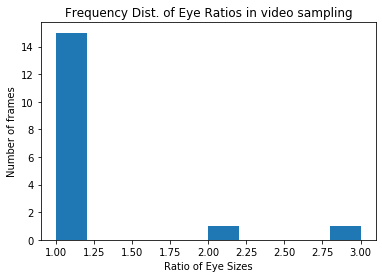

In [42]:
eye_rats = find_eye_rat_from_video("videos/MVI_3423.MP4")

0
Cat detected ^^
30
Cat detected ^^
60
Cat detected ^^
90
Cat detected ^^
120
Cat detected ^^
150
Cat detected ^^
180
Cat detected ^^
210
Cat detected ^^
240
Cat detected ^^
270
Cat detected ^^
330
Cat detected ^^
360
Cat detected ^^
390
Cat detected ^^


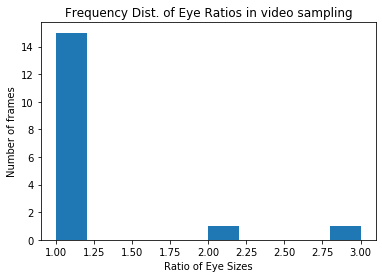

In [43]:
eye_rats_2 = find_eye_rat_from_video("videos/MVI_3427.MP4")

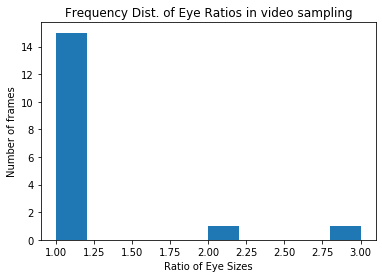

In [39]:
eye_ints = np.array([int(rat) for rat in eye_rats])
eye_ints
plt.hist(eye_ints)
plt.xlabel("Ratio of Eye Sizes")
plt.ylabel("Number of frames")
plt.title("Frequency Dist. of Eye Ratios in video sampling")
plt.show()

### FURTHER EXPERIMENTATION

In [ ]:
# I've noticed that sometimes, cat_cascade detects a cat whereas cat_extension doesn't.
# I haven't looked into this too much, so I wanted to modify the function
# so that the images where this was the case gets outputted.
# It looks like cat_cascade is a bit oversensitive,
# As these are rather shoddy images.

def process_video(filename, sample_rate=10):
    """
    A function that takes in a filename for a video
    determines if there is a cat present.
    
    You can pass in a sample rate. It is set
    by default to 10, so that only every 10th
    frame will get parsed. 
    """
    capture = cv2.VideoCapture(filename)    
    frame_count = 0
    
    while capture.isOpened():
        playing, frame = capture.read()
        
        if playing and frame_count % sample_rate == 0:
            img, cat, cat_ext, eyes = detect_cat(frame)
            print(cat, cat_ext)
            if len(cat) > 0 and len(cat_ext) == 0:
                print("cat_cascade picked up on a cat face, whereas cat_ext_cascade didn't. Saving image.")
                save_image(img, cat, cat_ext, eyes, f"test_output/cat_non_ext_{frame_count}")
        
        if not playing:
            break

        frame_count += 1

    capture.release()

process_video("videos/MVI_3414.MP4")

You can also look at the above output for an idea of what the data returned by the detectMultiScale looks like. 

Below are the images that vanilla cat detector picked up on, but the extension did not.

In [ ]:
non_ext1 =  mpimg.imread("test_output/cat_non_ext_140.jpg")
plt.imshow(non_ext1)

In [ ]:
non_ext2 =  mpimg.imread("test_output/cat_non_ext_200.jpg")
plt.imshow(non_ext1)

In [ ]:
non_ext3 =  mpimg.imread("test_output/cat_non_ext_270.jpg")
plt.imshow(non_ext3)

In [23]:
def get_data_and_frames_from_video(filenames, sample_rate=30):
    all_x = []
    all_y = []
    
    for filename in filenames:
        capture = cv2.VideoCapture(filename)    
        frame_count = 0
        cat_detected = 0
        eyes_detected = []
        boxes = []
        eye_boxes = []


        while capture.isOpened():
            playing, frame = capture.read()
            
            eye_rat = 0
            head_rat = 0

            if playing and frame_count % sample_rate == 0:
                img, cats, cats_ext, eyes = detect_cat(frame)
                if len(cats_ext) > 0:
                    print(frame_count)
                    print("Cat detected ^^")
                    cat_detected += 1
                    box_cleaned = [(cats_ext[0][2], cats_ext[0][3]), (frame.shape[0], frame.shape[1])]
                    box = box_cleaned[0]
                    frame_size = box_cleaned[1]
                    box_area = box[0]*box[1]
                    frame_area = frame_size[0]*frame_size[1]
                    head_rat= box_area/frame_area
                    #save_image(img, cats, cats_ext, eyes, f"test_output/cat_detected_{frame_count}")

                if len(eyes) > 1:
                    eyes_detected.append(eyes.shape[0])
                    eye_dims = np.array([eye[2]*eye[3] for eye in eyes])
                    top_two_eyes = eye_dims[np.argsort(eye_dims)[-2:]]
                    eye_rat = top_two_eyes[1]/top_two_eyes[0]

            if not playing:
                break

            if frame_count > 500:
                break

            frame_count += 1
            
            if (eye_rat != 0 and head_rat != 0):
                all_x.append((eye_rat, head_rat))
                all_y.append(frame)

        capture.release()
    return (all_x, all_y)

In [25]:
videos = np.array(["videos/MVI_3414.MP4", "videos/MVI_3427.MP4", "videos/MVI_3423.MP4"])
(all_x, all_y) = get_data_and_frames_from_video(videos)
print(all_x)

0
Cat detected ^^
30
Cat detected ^^
210
Cat detected ^^
0
Cat detected ^^
30
Cat detected ^^
60
Cat detected ^^
90
Cat detected ^^
120
Cat detected ^^
150
Cat detected ^^
180
Cat detected ^^
210
Cat detected ^^
240
Cat detected ^^
270
Cat detected ^^
330
Cat detected ^^
360
Cat detected ^^
390
Cat detected ^^
0
Cat detected ^^
30
Cat detected ^^
60
Cat detected ^^
90
Cat detected ^^
120
Cat detected ^^
150
Cat detected ^^
180
Cat detected ^^
210
Cat detected ^^
240
Cat detected ^^
270
Cat detected ^^
300
Cat detected ^^
330
Cat detected ^^
360
Cat detected ^^
390
Cat detected ^^
420
Cat detected ^^
450
Cat detected ^^
480
Cat detected ^^
[(1.0714065866420437, 0.011437114197530865), (38.51297577854671, 0.018337673611111112), (1.1168646694214877, 0.04225308641975309), (1.0, 0.050625), (1.1211072664359862, 0.04), (1.0888468809073724, 0.04938271604938271), (1.296094674556213, 0.035941840277777776), (1.0279706790123457, 0.05031298225308642), (1.0915571396747605, 0.04574845679012346), (1.0,

In [26]:
all_y_fixed = np.array([np.abs(eye-1) < 0.1 and np.abs(head- 0.05) < 0.03 for (eye, head) in all_x])
print(all_y_fixed)

[False False False  True False  True False  True  True  True False False
 False False False  True  True  True  True  True False  True False False
 False False  True  True False False  True False False]


In [27]:
from sklearn.linear_model import LogisticRegression
cat_model = LogisticRegression(random_state=0).fit(all_x, all_y_fixed)

//anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [34]:
cat_model.predict_proba(all_x)

array([[5.56375429e-01, 4.43624571e-01],
       [1.00000000e+00, 3.11494262e-14],
       [5.65085330e-01, 4.34914670e-01],
       [5.41128061e-01, 4.58871939e-01],
       [5.65983030e-01, 4.34016970e-01],
       [5.59278080e-01, 4.40721920e-01],
       [6.01100589e-01, 3.98899411e-01],
       [5.46854785e-01, 4.53145215e-01],
       [5.59890538e-01, 4.40109462e-01],
       [5.41314478e-01, 4.58685522e-01],
       [5.78876834e-01, 4.21123166e-01],
       [5.68083873e-01, 4.31916127e-01],
       [6.16031085e-01, 3.83968915e-01],
       [5.85163636e-01, 4.14836364e-01],
       [5.85237413e-01, 4.14762587e-01],
       [5.47218700e-01, 4.52781300e-01],
       [5.48774164e-01, 4.51225836e-01],
       [5.56299097e-01, 4.43700903e-01],
       [5.41285782e-01, 4.58714218e-01],
       [5.41295413e-01, 4.58704587e-01],
       [5.71933370e-01, 4.28066630e-01],
       [5.54991935e-01, 4.45008065e-01],
       [5.67338290e-01, 4.32661710e-01],
       [8.81066703e-01, 1.18933297e-01],
       [6.236385